# Dog Maker


In [1]:
from PIL import Image
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


In [2]:
def resizeFolder(directory, output, basewidth):
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            
            img = Image.open(os.path.join(directory, filename))
            img = img.resize((basewidth, basewidth), Image.ANTIALIAS)
            img.save(output + filename)


def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")


In [3]:
output_directory = 'images_resized/'
directory = 'Images/'
for filename in os.listdir(directory):
    
    resizeFolder(directory+filename, output_directory, 28)
    


In [4]:
output_directory = 'images_resized/'

images = []
for filename in os.listdir("images_resized"):
    im = np.asarray(Image.open(output_directory+filename))
    images.append(im)
    


In [5]:
# images[0][0]
# i = "n02085620_2706.jpg"))
img = Image.fromarray(images[-1], 'RGB')
# img.show()
img.show()

---

In [6]:
np.random.seed(42)
tf.random.set_seed(42)

codings_size = 30

generator = keras.models.Sequential(
    [
        keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(28 * 28 * 3, activation="sigmoid"),
        keras.layers.Reshape([28, 28, 3]),
    ]
)
discriminator = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28, 3]),
        keras.layers.Dense(150, activation="selu"),
        keras.layers.Dense(100, activation="selu"),
        keras.layers.Dense(1, activation="sigmoid"),
    ]
)
gan = keras.models.Sequential([generator, discriminator])

In [7]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [8]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

In [9]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [10]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))  # not shown in the book
        for X_batch in dataset:
            # phase 1 - training the discriminator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            generated_images = generator(noise)
            x_corrected = tf.cast(X_batch, tf.float32) 
            X_fake_and_real = tf.concat([generated_images, x_corrected], axis=0)
            y1 = tf.constant([[0.0]] * batch_size + [[1.0]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(X_fake_and_real, y1)
            # phase 2 - training the generator
            noise = tf.random.normal(shape=[batch_size, codings_size])
            y2 = tf.constant([[1.0]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y2)
        plot_multiple_images(generated_images, 8)  # not shown
        plt.show()  # not shown

Epoch 1/100


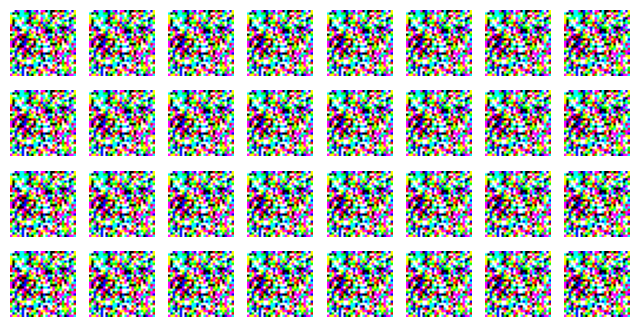

Epoch 2/100


In [ ]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=100)